<img src="static/photo2map.jpg" width=700 align="center"/>

# Photo -> Map
Disclaimer: this notebook is an adopted version of [this repository](https://github.com/GunhoChoi/Kind-PyTorch-Tutorial).

Previously, we used neural networks for **sparse** predictions: large input (image) -> small output (vector with 10 elements, e.g. CIFAR10 classes). Today we'll use deep learning to make **dense** predictions (large input (image) -> large output (image)) for **image-to-image translation problem**. *Image-to-image translation* is a wide class of problems, where input is image and output is image too (e.g. satellite photo -> map, image stylization, [sketch -> cat portrait](https://affinelayer.com/pixsrv/),  etc...). There many good models for dense predictions, but we'll use **UNet** as the best choice in terms of simplicity-quality ratio.

But before we start, let's look at our dataset.

## Task 1 (1 point). Dataset
We'll dataset of pairs **satellite photo - map** (example is above). To download dataset, uncomment and run command below:

In [1]:
#! wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz
#! tar -xzvf maps.tar.gz
#! mkdir maps/train/0 && mv maps/train/*.jpg maps/train/0
#! mkdir maps/val/0 && mv maps/val/*.jpg maps/val/0

Imports:

In [2]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms


Parameters:

In [3]:
experiment_title = "unet"

device = torch.device('cpu')#torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

batch_size = 4
image_size = 256

data_dir = "./maps"

transform = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

After downloading and unpacking you'll find directory `maps` with 2 subdirectories: `train` and `val`. Each image is a pair (photo - map), so we'll have to **crop image to obtain input and target**. Let's use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) dataloader: 

In [4]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Draw sample from dataset:

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
#(image, _) = train_dataset[0]
#imshow(image)

As we can see input and target are in the same image. Let's write wrapper of ImageFolder to return what we need:

In [6]:
class PhotoMapDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        photo_image, map_image = torch.chunk(sample, 2, dim=-1)
        
        return photo_image, map_image

In [24]:
train_dataset = PhotoMapDataset(root=os.path.join(data_dir, "train"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [23]:
val_dataset = PhotoMapDataset(root=os.path.join(data_dir, "val"), transform=transform)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

So now we have:

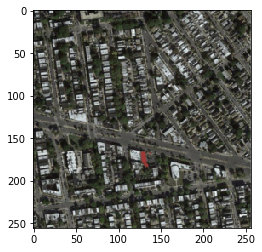

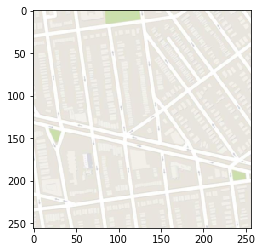

In [8]:
photo_image, map_image = train_dataset[0]
imshow(photo_image)
imshow(map_image)

Okay, we're don with data. Let's move to defining model.

## Task 2 (2 ponts). UNet
UNet is a very popular fully-convolutional architecture. Below you can find its sctructure (for more detatils refer to [original paper](https://arxiv.org/abs/1505.04597)):

<img src="static/unet.png" width=1000 align="center"/>

Let's build UNet!

In [9]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.Conv2d(out_channels, out_channels, 3, padding=1))
        if pooling:
            self.layers.append(nn.MaxPool2d(2))
        self.layers.append(nn.ReLU(inplace=True))
        
    def forward(self, x):
        x_before_pooling = x
        for n, layer in enumerate(self.layers):
            x = layer(x)
            if n == 2:
                x_before_pooling = x
        return x, x_before_pooling

In [10]:
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        
    def forward(self, x, x_bridge):
        
        x = self.upconv(x)
        x = self.relu(x)
        x = torch.cat([x, x_bridge], dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        return x

In [11]:
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels, depth=3, base_n_filters=64):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.depth = depth
        self.base_n_filters = base_n_filters
        self.layers = nn.ModuleList()
        temp_in_ch = in_channels
        temp_out_ch = base_n_filters
        for n in range(depth):
            self.layers.append(UnetDownBlock(temp_in_ch, temp_out_ch))
            temp_in_ch = temp_out_ch
            temp_out_ch *= 2
        self.layers.append(UnetDownBlock(temp_in_ch, temp_out_ch, pooling=False))
        temp_in_ch = temp_out_ch
        temp_out_ch //= 2
        for n in range(depth):
            self.layers.append(UnetUpBlock(temp_in_ch, temp_out_ch))
            temp_in_ch = temp_out_ch
            temp_out_ch //= 2
        self.layers.append(nn.Conv2d(temp_in_ch, out_channels, 3, padding=1))
        
    def forward(self, x):
        remember = []
        for n, layer in enumerate(self.layers):
            if n < self.depth + 1:
                x, x_before_pooling = layer(x)
                if n < self.depth:
                    remember.append(x_before_pooling)
            elif n < 2 * self.depth + 1:
                x = layer(x, remember.pop())
            else:
                x = layer(x)
        return x
    
    def __repr__(self):
        message = '{}(in_channels={}, out_channels={}, depth={}, base_n_filters={})'.format(
            self.__class__.__name__,
            self.in_channels, self.out_channels, self.depth, self.base_n_filters
        )
        return message

In [12]:
model = Unet(3, 3, depth=4, base_n_filters=64).to(device)
model

Unet(in_channels=3, out_channels=3, depth=4, base_n_filters=64)

## Train-loop

Optimization setup:

In [13]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0002)

TensorboardX setup:

In [ ]:
# !pip3 install tensorboardx

In [14]:
from tensorboardX import SummaryWriter
from datetime import datetime

experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
writer = SummaryWriter(log_dir=os.path.join("./tb", experiment_name))

Train-loop:

In [ ]:
n_epochs = 1
n_iters_total = 1644

model.train()

for epoch in range(n_epochs):
    total_loss = 0
    for batch in tqdm(train_dataloader):
        # unpack batch
        photo_image_batch, map_image_batch = batch
        photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)
        
        # forward
        map_image_pred_batch = model(photo_image_batch)
        loss = criterion(map_image_pred_batch, map_image_batch)
        total_loss += loss
        
        # optimize
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        
        if n_iters_total % 50 == 0:
            writer.add_image('train/photo_image', torchvision.utils.make_grid(photo_image_batch, normalize=True, scale_each=True), n_iters_total)
            writer.add_image('train/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch, normalize=True, scale_each=True), n_iters_total)
            writer.add_image('train/map_image_gt', torchvision.utils.make_grid(map_image_batch, normalize=True, scale_each=True), n_iters_total)
        
        n_iters_total += 1
        
    print("Epoch {} done.".format(epoch))

In [21]:
torch.save({'model': model.state_dict(), 'optimizer': opt.state_dict(), 'epoch': 6, 'loss': loss}, 'checkpoints/epoch6_mse_adam.pt')

## Run tensorboard

To look at your logs in tensorboard go to terminal and run command:
```bash
$ tensorboard --logdir PATH_TO_YOUR_LOG_DIR
```

Then go to browser to `localhost:6006` and you'll see beautiful graphs! Always use tensorbord to watch your experiment, because it's very important to check how training is going on.

## Task 3 (1 point). Validation

As you remember we have `val` images in our dataset. So, to make sure, that we didn't overfit to `train`, we should do evaluation on validation set. You're free to choose, how to insert validation in existing notebook:
1. Insert validation to train-loop (validate every epoch)
2. Validate 1 time after training

I highly recomend to implement first option with beautiful tensorboard logs. Have fun! :)

In [31]:
model.eval()
n_val_iters_total = 0
total_loss = 0

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        photo_image_batch, map_image_batch = batch
        photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)
        
        map_image_pred_batch = model(photo_image_batch)
        loss = criterion(map_image_pred_batch, map_image_batch)
        total_loss += loss.item()
        
        if n_val_iters_total % 50 == 0:
            writer.add_image('val/photo_image', torchvision.utils.make_grid(photo_image_batch, normalize=True, scale_each=True), n_val_iters_total)
            writer.add_image('val/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch, normalize=True, scale_each=True), n_val_iters_total)
            writer.add_image('val/map_image_gt', torchvision.utils.make_grid(map_image_batch, normalize=True, scale_each=True), n_val_iters_total)
        
        n_val_iters_total += 1

print(total_loss)


4.331919078715146


In [32]:
total_loss_6ep = 4.331919078715146